In [1]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.metrics import accuracy_score
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import gensim.downloader
from gensim.models import Word2Vec
from sklearn.linear_model import LinearRegression
import random
from itertools import combinations
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#data_path = "data/html/*.html"
data_path = "/content/drive/MyDrive/CS412_Course-Project/dataset/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:

        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )

        code2convos[file_code] = convo_texts

0it [00:00, ?it/s]


In [5]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

KeyError: '0031c86e-81f4-4eef-9e0e-28037abf9883'

#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [ ]:
prompts = []
code2prompts = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"])
            user_prompts.append(conv["text"])
    code2prompts[code] = user_prompts

In [ ]:
prompts[0]

"Load a CSV file into a Pandas in Python. The file is named 'cs412_hw1_dataset.csv' and contains columns like 'Species', 'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and 'Health Metrics'. \n"

In [ ]:
questions = [
    """Initialize
*   First make a copy of the notebook given to you as a starter.
*   Make sure you choose Connect form upper right.
*   You may upload the data to the section on your left on Colab, than right click on the .csv file and get the path of the file by clicking on "Copy Path". You will be using it when loading the data.

""",
#####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]

In [ ]:
def preprocess_text(text):
    """
    Preprocesses the input text using NLTK.

    Parameters:
    - text (str): Input text to be preprocessed.

    Returns:
    - list: Preprocessed tokens.
    """

    # Tokenization
    tokens = word_tokenize(text)

    # Convert to lowercase
    tokens = [word.lower() for word in tokens]

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]

    # Remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    return words


# Apply preprocessing to each string in the list
preprocessed_propmts = [preprocess_text(text) for text in prompts]
preprocessed_questions = [preprocess_text(text) for text in questions]

# Join each inner list into a single string
preprocessed_propmts = [' '.join(inner_list) for inner_list in preprocessed_propmts]
preprocessed_questions = [' '.join(inner_list) for inner_list in preprocessed_questions]

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(preprocessed_propmts + preprocessed_questions)

In [ ]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

,aall,aany,abciterable,abcseries,ability,abiout,able,abs,absolute,accept,...,ytrainpred,ytrainrootsplit,ytrainshape,ytrainunique,yvalues,zaman,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [ ]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"]

,aall,aany,abciterable,abcseries,ability,abiout,able,abs,absolute,accept,...,ytrainpred,ytrainrootsplit,ytrainshape,ytrainunique,yvalues,zaman,zero,zerodivisionerror,zeroth,zip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125908,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 3955)

In [ ]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [ ]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [ ]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.104315,0.328787,0.496068,0.264623,0.433469,0.607781,0.137037,0.109817,0.127557
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.164311,0.793324,0.753977,0.814326,0.616862,0.990032,0.888019,0.702165,0.534528
2,041f950b-c013-409a-a642-cffff60b9d4b,0.078312,0.246569,0.485493,0.296449,0.653025,0.371072,0.458811,0.491271,0.249321
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.052830,0.170351,0.174006,0.283410,0.319436,0.378677,0.271392,0.217788,0.417837
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.365054,0.652358,0.778322,0.588387,0.749378,0.891856,0.732145,0.940824,0.496740
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.095432,0.162299,0.225945,0.190881,0.176992,0.441929,1.000000,0.955333,0.751195
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.052098,0.105670,0.284382,0.919454,0.802039,0.838653,0.325076,0.904978,0.643260
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.134801,0.966993,0.976658,0.918610,0.907662,0.916704,0.717235,0.845256,0.499175
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.134801,0.966993,1.000000,0.629023,0.963901,0.908597,1.000000,1.000000,0.762283


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [ ]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1

            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [ ]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [ ]:
# reading the scores
scores = pd.read_csv("/content/drive/MyDrive/CS412_Course-Project/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


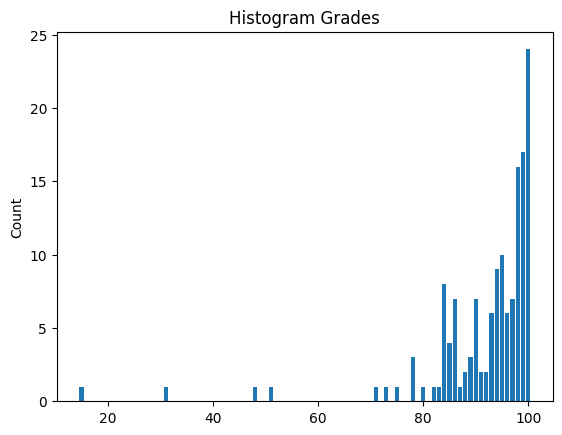

In [ ]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [ ]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [ ]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.104315,0.328787,0.496068,0.264623,0.433469,0.607781,0.137037,0.109817,0.127557
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.164311,0.793324,0.753977,0.814326,0.616862,0.990032,0.888019,0.702165,0.534528
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.078312,0.246569,0.485493,0.296449,0.653025,0.371072,0.458811,0.491271,0.249321
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.052830,0.170351,0.174006,0.283410,0.319436,0.378677,0.271392,0.217788,0.417837
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.365054,0.652358,0.778322,0.588387,0.749378,0.891856,0.732145,0.940824,0.496740


#### Merging scores with features

In [ ]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.104315,0.328787,0.496068,0.264623,0.433469,0.607781,0.137037,0.109817,0.127557,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.164311,0.793324,0.753977,0.814326,0.616862,0.990032,0.888019,0.702165,0.534528,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.078312,0.246569,0.485493,0.296449,0.653025,0.371072,0.458811,0.491271,0.249321,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.052830,0.170351,0.174006,0.283410,0.319436,0.378677,0.271392,0.217788,0.417837,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.365054,0.652358,0.778322,0.588387,0.749378,0.891856,0.732145,0.940824,0.496740,100.0


In [ ]:
temp_df = temp_df[temp_df['grade'] > 60]


In [ ]:
#DATA AUGMENTATION

#For row pairs that has the same grade, randomly pick colums from either of them, and create a new row
#Assumtion here is that combination of fetures from the same grade will result in same or at least similar grade



def augment_table(temp_df):
  duplicate_rows = temp_df[temp_df.duplicated(subset=['grade'], keep=False)]

  # Create an empty list to store new rows
  new_rows = []

  # Iterate over duplicates
  for _, group in duplicate_rows.groupby('grade'):
      # Generate all pairs of rows with the same grade
      pairs = list(combinations(group.iterrows(), 2))

      # Create new rows for each pair
      for (idx1, row1), (idx2, row2) in pairs:
          # Create a new row by randomly selecting columns from both rows
          new_row = {'grade': row1['grade']}  # Assuming grade remains unchanged

          # Randomly select columns from the two rows
          for col in temp_df.columns:  # Loop through all columns
              if col != 'grade':  # Skip the 'grade' column
                  new_row[col] = random.choice([row1[col], row2[col]])  # Randomly select value from row1 or row2

          # Append the new row to the list
          new_rows.append(new_row)

  # Convert the list of new rows to a DataFrame
  new_df = pd.DataFrame(new_rows)

  # Concatenate the original dataframe with the new rows
  final_df = pd.concat([temp_df, new_df], ignore_index=True)
  return final_df

In [ ]:
X = temp_df[temp_df.columns[1:-1]]
y = temp_df["grade"]
print(X.shape, y.shape)

(118, 17) (118,)


#### Train/Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 94
Test set size: 24


In [ ]:
added = pd.concat([X_train, y_train], axis=1)
augmented = augment_table(added)

X_train = augmented[temp_df.columns[1:-1]]
y_train = augmented["grade"]

#### Fitting a model

#### Predicting and Analyzing

In [ ]:
# Define the RandomForestRegressor
random_forest_model = RandomForestRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [18,20,22,24],
    'min_samples_split': [2,3,4,5],
    "max_depth": [6,8,10,12,14]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Best model
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) with best model: {mse}")


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'max_depth': 12, 'min_samples_split': 4, 'n_estimators': 22}
Mean Squared Error (MSE) with best model: 58.852376430900144


In [ ]:
#This params are better than what grid search finds
regressor = RandomForestRegressor(random_state=42, n_estimators=26, max_depth=14)
regressor.fit(X_train, y_train)
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 1.3731629760742743
MSE TEST: 57.274740518245835
R2 Train: 0.9330785036630758
R2 TEST: 0.007961192647433446


In [ ]:
# Define the RandomForestRegressor
tree_regressor = DecisionTreeRegressor(random_state=42)

# Define the parameter grid
param_grid = {
    "min_samples_split" : [2,4,6,8,10],
    "max_depth": [12]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Best model
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE) with best model: {mse}")


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters: {'max_depth': 12, 'min_samples_split': 4}
Mean Squared Error (MSE) with best model: 75.23642690603161


In [ ]:
tree_regressor = DecisionTreeRegressor(random_state=42,criterion='squared_error', max_depth=10)
tree_regressor.fit(X_train, y_train)

# Prediction
y_train_pred = tree_regressor.predict(X_train)
y_test_pred = tree_regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 0.3626646940515553
MSE TEST: 76.180348891191
R2 Train: 0.9823254308356839
R2 TEST: -0.31949724737110263


In [ ]:
# Get feature importances
feature_importances = regressor.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the DataFrame in descending order of feature importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display most important feature at the top
plt.show()
